

**Problem Statement:**

Goal: Create a unified hybrid framework that adapts to the commodity type and automatically selects or combines the best models accordingly.

We loaded historical data from 2003-April 2025 alonmg with new realtime data to predict price with pre trained model.

## Step 8 Processing Real Time Data with Pre Trained Models

##### Sourcing Key Libraries


In [1]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np 
import os 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.formula.api as smf
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import statsmodels.formula.api as smf
# from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima.model import ARIMA
#from pmdarima.arima import auto_arima
import pmdarima as pm
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.ensemble import RandomForestRegressor
import os
import itertools
import requests
import yfinance as yf
from scipy.stats import randint
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.models import Sequential
#from arch import arch_model
from transformers import pipeline
#from xgboost import XGBRegressor
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

##### Define constant Variables

In [2]:
# constant values
# Your API Key from FRED
api_key = 'a27b910873da479a5561ea08035a6c79'
# API Key for Alpha Vantage (Replace with your actual key)
API_KEY_alpha = "3J4EGZCB0D7UT9WG"
# genertae your APi key from here: https://www.alphavantage.co/

#update the below code for any new precious Metal

data_ticker_map = {
            'GOLD' : 'GC=F',
            'SILVER': 'SI=F',
            'CRUDE_OIL': 'CL=F'}

data_file_mapping = {
            'GOLD' : '../../Data/Historical_Gold_data_April_2015.csv',
           'SILVER': '../../Data/Historical_Silver_data_April_2015.csv',
           'CRUDE_OIL': '../../Data/Historical_Crude_oil_data_April_2015.csv',}

Live_Sentiments_file_name = 'Live_Sentiments.csv'
Live_Sentiments_file_dir = '../../Sentiments'
Historical_Sentiments_file_name = 'Historical_Sentiments.csv'
Historical_Sentiments_file_dir = '../../Sentiments'

best_models_dir = {'GOLD': '../../Models/GOLD_MODELS', 'SILVER' : '../../Models/SILVER_MODELS', 'CRUDE_OIL': '../../Models/CRUDE_OIL_MODELS'}
hybrid_models_dir = {'GOLD': '../../Models/GOLD_HYBRID_MODELS', 'SILVER' : '../../Models/SILVER_HYBRID_MODELS', 'CRUDE_OIL': '../../Models/CRUDE_OIL_HYBRID_MODELS'}
hybrid_meta_models_dir = {'GOLD': '../../Models/GOLD_HYBRID_MODELS/Meta', 'SILVER' : '../../Models/SILVER_HYBRID_MODELS/Meta', 'CRUDE_OIL': '../../Models/CRUDE_OIL_HYBRID_MODELS/Meta'}

### Enter Commodity Name for which you want to predict Price EX: GOLD, SILVER, CRUDE OIL etc

In [3]:
commodity = 'SILVER' #input('Enter the Commodity Name')
filename =  data_file_mapping.get(commodity)

## Data Sourcing

### Historical Data Sourcing

##### Yahoo finance is not reliable and having issues, download data from 2003-01-01 - 2025-03-15 via yf api.

##### Define function to download Historical data 

In [4]:
# Function to download historical price data
def download_price_data(ticker, start='2015-01-01', end='2025-04-05'):
    # Download the data
    data = yf.download(ticker, start=start, end=end)
    
    # Reset index to turn 'Date' into a regular column
    data.reset_index(inplace=True)
    
    # Flatten the columns if there are multiple levels
    data.columns = data.columns.get_level_values(0) if isinstance(data.columns, pd.MultiIndex) else data.columns
    
    # Select necessary columns only
    data = data[['Date', 'Open', 'High', 'Low', 'Close', 'Volume']]
    return data

# Load or download data for each commodity
def load_or_download_data(ticker, filename):
    if os.path.exists(filename):
        # Read the CSV, treating the first row as the header
        data = pd.read_csv(filename, header=0)
        
        # Convert 'Date' column to datetime format, and handle parsing errors
        data['Date'] = pd.to_datetime(data['Date'], errors='coerce')
        
        # Remove any rows where 'Date' could not be parsed and resulted in NaT
        data = data.dropna(subset=['Date'])
    else:
        # Download the data
        data = download_price_data(ticker)
        
        # Save to CSV with a single header row
        data.to_csv(filename, index=False)
    
    # Ensure the 'Close' column is numeric
    data['Close'] = pd.to_numeric(data['Close'], errors='coerce')
    
    return data


In [5]:
############# Reading Data Sources #################
print(f'Loading from Historical file id Data available in file : {filename}')
ticker = data_ticker_map.get(commodity)
print(f'Ticker code for {commodity} : {ticker}')
commodity_data = load_or_download_data(ticker, filename)

Loading from Historical file id Data available in file : ../../Data/Historical_Silver_data_April_2015.csv
Ticker code for SILVER : SI=F
YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [6]:
commodity_data


Price,Date,Open,High,Low,Close,Volume
0,2015-01-02,15.790000,15.815000,15.535000,15.734000,13
1,2015-01-05,16.179001,16.179001,16.179001,16.179001,0
2,2015-01-06,16.603001,16.603001,16.603001,16.603001,2
3,2015-01-07,16.480000,16.549999,16.480000,16.510000,9
4,2015-01-08,16.351000,16.351000,16.351000,16.351000,0
...,...,...,...,...,...,...
2573,2025-03-31,34.759998,35.000000,34.400002,34.457001,97
2574,2025-04-01,34.599998,34.665001,34.158001,34.158001,97
2575,2025-04-02,34.499001,34.855000,34.499001,34.499001,558
2576,2025-04-03,34.134998,34.134998,31.625000,31.844000,63


### Sourcing Market data

####  GDP data

##### Define function which will convert Yearly GDP data to daily GDP data

In [7]:
def expand_gdp_to_daily(gdp_df):
    daily_gdp = []
    for index, row in gdp_df.iterrows():
        month_start = row['Date']
        value = row['Value']
        month_days = pd.date_range(start=month_start, end=month_start + pd.offsets.MonthEnd(0), freq='D')
        for day in month_days:
            daily_gdp.append({'Date': day, 'Value': value})
    return pd.DataFrame(daily_gdp)


def preprocess_gdp_data(gdp_data):
    gdp_data['Date'] = pd.to_datetime(gdp_data['Date'])
    return expand_gdp_to_daily(gdp_data)


def fetch_world_bank_data(indicator, country='USA', start_year='2003', end_year='2025'):
    url = f'http://api.worldbank.org/v2/country/{country}/indicator/{indicator}?date={start_year}:{end_year}&format=json'
    try:
        response = requests.get(url)
        data = response.json()
        if len(data) < 2 or 'message' in data[1]:
            print("No data found for the specified parameters.")
            return None
        df = pd.json_normalize(data[1])
        df['date'] = pd.to_datetime(df['date'])
        df = df[(df['date'] >= f'{start_year}-01-01') & (df['date'] <= f'{end_year}-12-31')]
        df = df[['date', 'value']]
        df.columns = ['Date', 'Value']
        return df
    except Exception as e:
        print(f"Error fetching data: {e}")
        return None


In [8]:
############### sourcing world GDP data #################################################
gdp_data = fetch_world_bank_data('NY.GDP.MKTP.CD', country='USA', start_year='2003', end_year='2024')
daily_gdp_data = preprocess_gdp_data(gdp_data)
daily_gdp_data.rename(columns={'Value':'GDP'},inplace=True)
daily_gdp_data

,Date,GDP
0,2024-01-01,NaT
1,2024-01-02,NaT
2,2024-01-03,NaT
3,2024-01-04,NaT
4,2024-01-05,NaT
...,...,...
677,2003-01-27,11456450000000.0
678,2003-01-28,11456450000000.0
679,2003-01-29,11456450000000.0
680,2003-01-30,11456450000000.0


####  Interest rate data

In [9]:

############## Sourcing Interest rate data ################################
from fredapi import Fred

# Your API Key from FRED
api_key = 'a27b910873da479a5561ea08035a6c79'

# Initialize the FRED API
fred = Fred(api_key=api_key)

# Fetch the Federal Funds Rate data (you can change this to any other indicator)
# Federal Funds Rate is often identified by the FRED ID 'FEDFUNDS'
interest_rate_data = fred.get_series('FEDFUNDS' ,start_date='2003-01-01')

# Convert the data into a DataFrame for better handling
interest_rate_df = pd.DataFrame(interest_rate_data)
interest_rate_df.columns = ['Interest_rates']

# Reset the index to have 'Date' as a column
interest_rate_df.reset_index(inplace=True)

import pandas as pd

# Assuming `interest_rate_df` already exists with 'Date' and 'Interest_rates' columns

# Convert 'Date' column to datetime format if it’s not already
interest_rate_df['Date'] = pd.to_datetime(interest_rate_df['index'])
interest_rate_df.drop(columns=['index'], inplace=True)  # Drop the old index column if needed

# Create a date range for every day from the start to the end of the interest rate data
start_date = interest_rate_df['Date'].min()
end_date = interest_rate_df['Date'].max()
date_range = pd.date_range(start=start_date, end=end_date, freq='D')

# Create a new DataFrame with daily dates as a column
daily_interest_rate_df = pd.DataFrame({'date': date_range})

# Add a 'month' and 'year' column to `interest_rate_df` for easy merging
interest_rate_df['year'] = interest_rate_df['Date'].dt.year
interest_rate_df['month'] = interest_rate_df['Date'].dt.month

# Merge monthly data with daily data on matching 'year' and 'month'
daily_interest_rate_df['year'] = daily_interest_rate_df['date'].dt.year
daily_interest_rate_df['month'] = daily_interest_rate_df['date'].dt.month

# Perform a left join on 'year' and 'month' columns
daily_interest_rate_df = daily_interest_rate_df.merge(
    interest_rate_df[['year', 'month', 'Interest_rates']],
    on=['year', 'month'],
    how='left'
)

# Drop the extra columns, keep only 'date' and 'Interest_rates'
daily_interest_rate_data = daily_interest_rate_df[['date', 'Interest_rates']]
daily_interest_rate_data.rename(columns={'date':'Date'},inplace=True)
daily_interest_rate_data


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_33100\1493415932.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_interest_rate_data.rename(columns={'date':'Date'},inplace=True)


,Date,Interest_rates
0,1954-07-01,0.80
1,1954-07-02,0.80
2,1954-07-03,0.80
3,1954-07-04,0.80
4,1954-07-05,0.80
...,...,...
25838,2025-03-28,4.33
25839,2025-03-29,4.33
25840,2025-03-30,4.33
25841,2025-03-31,4.33


####  GDP to Debt data

In [10]:
################## GDP to Debt DATA ###############################
import wbdata
import pandas as pd
import datetime

# Set the start and end dates for the data
start_date = datetime.datetime(2000, 1, 1)
end_date = datetime.datetime(2025, 1, 1)

# List of indicators to retrieve (Government Debt to GDP ratio)
indicators = {'GC.DOD.TOTL.GD.ZS': 'Government Debt to GDP'}

# Fetch data from the World Bank API for the USA
government_debt_data = wbdata.get_dataframe(indicators, country='USA')

# Fill missing values in `Government Debt to GDP` with 0
government_debt_data['Government Debt to GDP'] = government_debt_data['Government Debt to GDP'].fillna(0)

# Reset index to make `date` a regular column and convert it to datetime
government_debt_data.reset_index(inplace=True)
government_debt_data['date'] = pd.to_datetime(government_debt_data['date'])

# Add a 'year' column to `government_debt_data` to help with mapping
government_debt_data['year'] = government_debt_data['date'].dt.year

# Create a dictionary for quick lookup of Debt to GDP per year
debt_to_gdp_dict = government_debt_data.set_index('year')['Government Debt to GDP'].to_dict()

# Create a date range for every day from the start to the end date
date_range = pd.date_range(start=start_date, end=end_date, freq='D')

# Create a new DataFrame with daily dates as a column
daily_debt_data = pd.DataFrame({'date': date_range})

# Map each date in `daily_debt_data` to the corresponding Debt to GDP value for that year
daily_debt_data['DebtToGDP'] = daily_debt_data['date'].dt.year.map(debt_to_gdp_dict)
daily_debt_data.rename(columns={'date':'Date'},inplace=True)

daily_debt_data

,Date,DebtToGDP
0,2000-01-01,33.267642
1,2000-01-02,33.267642
2,2000-01-03,33.267642
3,2000-01-04,33.267642
4,2000-01-05,33.267642
...,...,...
9128,2024-12-28,NaN
9129,2024-12-29,NaN
9130,2024-12-30,NaN
9131,2024-12-31,NaN


####  Inflation data

In [11]:
############## inflation data #################
# Get historical CPI data (Consumer Price Index) to calculate inflation
cpi_data = fred.get_series('CPIAUCSL', start_date='2003-01-01')



# Convert the data into a DataFrame for better handling
Inflation_data = pd.DataFrame(interest_rate_data)
Inflation_data.columns = ['Inflation_rate']

# Reset the index to have 'Date' as a column
Inflation_data.reset_index(inplace=True)
Inflation_data.rename(columns={'index':'Date'},inplace=True)
# Print the first few rows
Inflation_data

,Date,Inflation_rate
0,1954-07-01,0.80
1,1954-08-01,1.22
2,1954-09-01,1.07
3,1954-10-01,0.85
4,1954-11-01,0.83
...,...,...
845,2024-12-01,4.48
846,2025-01-01,4.33
847,2025-02-01,4.33
848,2025-03-01,4.33


####  ETF data

In [12]:
################ Gold ETF data ###########################################
import requests
import pandas as pd

# Fetch ETF data from FRED API
def fetch_fred_etf_data(series_id, api_key, start_date='2003-01-01', end_date='2025-03-28'):
    url = f'https://api.stlouisfed.org/fred/series/observations?series_id={series_id}&api_key={api_key}&file_type=json&observation_start={start_date}&observation_end={end_date}'
    response = requests.get(url)
    data = response.json()
    
    # Print the entire JSON response for inspection
    print("Full JSON response:", data)
    
    # Check for errors in the JSON response
    if "observations" not in data:
        print("Error: 'observations' key not found in the response. Check the series ID or API request.")
        return None
    
    # Parse JSON data into a DataFrame
    etf_df = pd.DataFrame(data['observations'])
    etf_df['Date'] = pd.to_datetime(etf_df['date'])
    etf_df['Date'] = etf_df['Date'].dt.tz_localize(None).dt.date 
    etf_df['value'] = pd.to_numeric(etf_df['value'], errors='coerce')
    etf_df.set_index('Date', inplace=True)
    
    return etf_df

# Example usage
api_key = 'a27b910873da479a5561ea08035a6c79'
series_id = 'INTDSRUSM193N'  # Replace with a valid series ID from FRED
etf_data = fetch_fred_etf_data(series_id, api_key)


etf_data.rename(columns={'value':'ETF_Value'},inplace=True)
# Only print if data retrieval was successful
if etf_data is not None:
    print(etf_data.head())

Full JSON response: {'realtime_start': '2025-05-02', 'realtime_end': '2025-05-02', 'observation_start': '2003-01-01', 'observation_end': '2025-03-28', 'units': 'lin', 'output_type': 1, 'file_type': 'json', 'order_by': 'observation_date', 'sort_order': 'asc', 'count': 224, 'offset': 0, 'limit': 100000, 'observations': [{'realtime_start': '2025-05-02', 'realtime_end': '2025-05-02', 'date': '2003-01-01', 'value': '2.25'}, {'realtime_start': '2025-05-02', 'realtime_end': '2025-05-02', 'date': '2003-02-01', 'value': '2.25'}, {'realtime_start': '2025-05-02', 'realtime_end': '2025-05-02', 'date': '2003-03-01', 'value': '2.25'}, {'realtime_start': '2025-05-02', 'realtime_end': '2025-05-02', 'date': '2003-04-01', 'value': '2.25'}, {'realtime_start': '2025-05-02', 'realtime_end': '2025-05-02', 'date': '2003-05-01', 'value': '2.25'}, {'realtime_start': '2025-05-02', 'realtime_end': '2025-05-02', 'date': '2003-06-01', 'value': '2'}, {'realtime_start': '2025-05-02', 'realtime_end': '2025-05-02', 'd

## Sourcing Sentiment Data and Apply BERT

#### Sourcing Live Sentiments

In [13]:
import requests
import pandas as pd
from transformers import pipeline
from datetime import datetime, timedelta

# Set up NewsAPI
API_KEY = "250e051931514de6b0e5120412c4e3ad"
NEWS_API_URL = "https://newsapi.org/v2/everything"

# Fetch news using query
def fetch_news(query, language="en", page_size=100):
    params = {
        "q": query,
        "language": language,
        "apiKey": API_KEY,
        "pageSize": page_size,
        "sortBy": "publishedAt",
    }
    response = requests.get(NEWS_API_URL, params=params)
    data = response.json()
    
    if data.get("status") == "ok":
        articles = data.get("articles", [])
        return [(article["publishedAt"], article["title"]) for article in articles]
    else:
        print("Error fetching news:", data)
        return []

# Load FinBERT pipeline
sentiment_pipeline = pipeline("text-classification", model="ProsusAI/finbert")

def analyze_sentiment(texts):
    sentiments = sentiment_pipeline(texts, truncation=True)
    return [sent["label"] for sent in sentiments]

# Combined sentiment fetcher for crude oil-related queries
def get_silver_sentiment():
    queries =  [
    "silver price",
    "silver futures",
    "silver market",
    "silver trading",
    "silver commodity",
    "silver ETF",
    "precious metals",
    "silver demand",
    "silver mining"
]
    all_articles = []

    for query in queries:
        articles = fetch_news(query)
        all_articles.extend(articles)

    if not all_articles:
        return pd.DataFrame()

    df = pd.DataFrame(all_articles, columns=["Date", "Headline"])
    df["Sentiment"] = analyze_sentiment(df["Headline"].tolist())
    df.to_csv("gold_sentiment_data.csv", index=False)
    return df


#### Apply Sentiment analysis on Live data and save them in disk

In [14]:
# Save the new data
import os
Live_Sentiments_file = os.path.join(Live_Sentiments_file_dir, commodity.upper(), Live_Sentiments_file_name)
if os.path.exists(Live_Sentiments_file):
        # sentiment_df = get_silver_sentiment()
        # sentiment_df.to_csv(Live_Sentiments_file, index=False)
        sentiment_df =  pd.read_csv(Live_Sentiments_file)  # File does not exist
else:
    # Fetch sentiment data
    sentiment_df = get_silver_sentiment()
    sentiment_df.to_csv(Live_Sentiments_file, index=False)
print(sentiment_df.head())
sentiment_df['Sentiment_score'] = sentiment_df['Sentiment'].apply(lambda x: 1 if x == 'positive' else -1 if x == 'negative' else 0)
print(sentiment_df.head())

# Add sentiment data back to the news_df
sentiment_df[['Date', 'Headline', 'Sentiment', 'Sentiment_score']]
live_sentiments_df = sentiment_df[['Date', 'Headline', 'Sentiment', 'Sentiment_score']]
# # Print out the resulting dataframe
# print(news_df[['Date', 'Title', 'Sentiment']].head())

# Convert Date column to datetime and add a range of days around each event
live_sentiments_df['Date'] = pd.to_datetime(live_sentiments_df['Date'])



live_sentiments_df['Date'] = pd.to_datetime(live_sentiments_df['Date'], errors='coerce')
live_sentiments_df['Date'] = live_sentiments_df['Date'].dt.tz_localize(None).dt.date 
live_sentiments_df.head()

                   Date                                           Headline  \
0  2025-04-30T09:00:48Z            Fortuna renews share repurchase program   
1  2025-04-30T09:00:01Z  How Ozempic and Other GLP-1 Drugs Are Eating A...   
2  2025-04-30T09:00:00Z            Fortuna renews share repurchase program   
3  2025-04-30T08:50:47Z  Geode Capital Management LLC Has $1.57 Million...   
4  2025-04-30T08:44:13Z  CANADA LIFE ASSURANCE Co Sells 1,375 Shares of...   

  Sentiment  
0   neutral  
1  negative  
2   neutral  
3   neutral  
4   neutral  
                   Date                                           Headline  \
0  2025-04-30T09:00:48Z            Fortuna renews share repurchase program   
1  2025-04-30T09:00:01Z  How Ozempic and Other GLP-1 Drugs Are Eating A...   
2  2025-04-30T09:00:00Z            Fortuna renews share repurchase program   
3  2025-04-30T08:50:47Z  Geode Capital Management LLC Has $1.57 Million...   
4  2025-04-30T08:44:13Z  CANADA LIFE ASSURANCE Co Sells 1

,Date,Headline,Sentiment,Sentiment_score
0,2025-04-30,Fortuna renews share repurchase program,neutral,0
1,2025-04-30,How Ozempic and Other GLP-1 Drugs Are Eating A...,negative,-1
2,2025-04-30,Fortuna renews share repurchase program,neutral,0
3,2025-04-30,Geode Capital Management LLC Has $1.57 Million...,neutral,0
4,2025-04-30,"CANADA LIFE ASSURANCE Co Sells 1,375 Shares of...",neutral,0


#### Load Historical Sentiment data

In [15]:
Historical_Sentiments_file = os.path.join(Historical_Sentiments_file_dir, commodity.upper(), Historical_Sentiments_file_name)
#Detect Invalid Dates
def is_invalid_date(date_str):
    try:
        pd.to_datetime(date_str, format="%d-%m-%Y", errors="raise")
        return False  # Valid date
    except:
        return True   # Invalid date



if os.path.exists(Historical_Sentiments_file) and commodity.upper()=="GOLD":
        historical_news_df =  pd.read_csv(Historical_Sentiments_file)  # File does not exist
        print(historical_news_df)
elif commodity.upper()=="GOLD" :
    # Fetch sentiment data
    historical_sentiment_data = pd.read_csv("C:/Users/Lenovo/OneDrive/Desktop/War/code/data/gold_historical_sentiments.csv", usecols=["Dates","Price Sentiment", "News"])
    historical_sentiment_data = historical_sentiment_data[~historical_sentiment_data["Dates"].astype(str).apply(is_invalid_date)]
    
    
    # Add sentiment data back to the news_df
    # # Print out the resulting dataframe
    # print(news_df[['Date', 'Title', 'Sentiment']].head())
    historical_news_df = historical_sentiment_data[['Dates', 'News', 'Price Sentiment', 'Sentiment_score']]
    historical_news_df.rename(columns = {'News':'Headline', 'Dates':'Date', 'Price Sentiment':'Sentiment'}, inplace = True)
    
    # Convert Date column to datetime and add a range of days around each event
    historical_news_df['Date'] = pd.to_datetime(historical_news_df['Date'])
    historical_news_df['Date'] = pd.to_datetime(historical_news_df['Date'], errors='coerce')
    historical_news_df['Date'] = historical_news_df['Date'].dt.tz_localize(None).dt.date 

    historical_news_df = historical_news_df[['Date','Headline']]
    historical_news_df["Sentiment_score"] = analyze_sentiment(historical_news_df["Headline"].tolist(), batch_size=16)
    historical_news_df['Sentiment_score'] = historical_news_df['Sentiment_score'].apply(lambda x: 1 if x == 'positive' else -1 if x == 'negative' else 0)
    historical_news_df.to_csv(Historical_Sentiments_file, index=False)
else:
    historical_news_df=live_sentiments_df




In [16]:

import pandas as pd
import requests
from transformers import pipeline

# Step 1: Define the events
events = {
    '2003-03-20': 'Iraq War begins, leading to regional instability and oil price increase',
    '2011-01-25': 'Arab Spring uprisings cause oil production disruptions',
    '2022-02-24': 'Russian invasion of Ukraine impacts oil prices due to sanctions and supply disruptions',
    '2008-09-15': 'Aftermath of 2008 Financial Crisis on Oil Prices',
    '2024-01-10': 'U.S. Announces New Sanctions on Russia',
    '2024-02-15': 'Ukraine Military Counteroffensive',
    '2024-03-05': 'Israel-Hamas Conflict Escalation',
    '2024-04-12': 'Iran Nuclear Talks Stalled'
}

# Step 2: Create a DataFrame for the events
event_df = pd.DataFrame(list(events.items()), columns=['Date', 'Title'])

# Step 3: Load the sentiment analysis pipeline
sentiment_pipeline = pipeline('sentiment-analysis')

# Step 4: Perform sentiment analysis on the event titles
event_sentiments = sentiment_pipeline(event_df['Title'].tolist())

# Step 5: Convert sentiment analysis results to DataFrame
sentiment_df = pd.DataFrame(event_sentiments)

# Step 6: Map sentiment labels to numerical values
event_df['Sentiment'] = sentiment_df['label'].apply(lambda x: 1 if x == 'POSITIVE' else -1 if x == 'NEGATIVE' else 0)
# Step 8: Convert 'Date' to datetime for merging

event_df['Date'] = pd.to_datetime(event_df['Date'], errors='coerce')
event_df['Date'] = event_df['Date'].dt.tz_localize(None).dt.date 
#gold_data['Date'] = pd.to_datetime(gold_data['Date']).dt.tz_localize(None).dt.date 
event_df.head()
historical_news_df = event_df
historical_news_df.rename(columns={'Sentiment':'Sentiment_score'},inplace=True)

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


## Step 2 : Data Preprocessing and Cleaning

### 2.1 Null Value Treatment

In [17]:
for data in [commodity_data]:
    data.dropna(subset=['Date', 'Close'], inplace=True)

### 2.2 Converting Values to Datetime format

In [18]:
# COnvert into date format
# Historical Data
# Convert Date column in gold_data to remove timezone
commodity_data['Date'] = commodity_data['Date'].dt.tz_localize(None).dt.date 

# Market Economic Data
daily_gdp_data['Date'] = daily_gdp_data['Date'].dt.tz_localize(None).dt.date 
interest_rate_df['Date'] = interest_rate_df['Date'].dt.tz_localize(None).dt.date 
Inflation_data['Date'] = Inflation_data['Date'].dt.tz_localize(None).dt.date 
daily_debt_data['Date'] = daily_debt_data['Date'].dt.tz_localize(None).dt.date 

### 2.3 Merging all source data to final data frame

In [19]:
# Merge all dataframes on 'Date' with 'gold_data' as the base (left join)
merged_data = commodity_data.merge(daily_gdp_data, on='Date', how='left') \
                       .merge(interest_rate_df, on='Date', how='left') \
                       .merge(Inflation_data, on='Date', how='left') \
                       .merge(daily_debt_data, on='Date', how='left') \
                        .merge(etf_data[['ETF_Value']], on='Date', how='left')

merged_data.drop(columns=['year','month'],inplace=True)

In [20]:
merged_data.info()
# Print summary of missing values after imputation
print(merged_data.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2578 entries, 0 to 2577
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Date            2578 non-null   object 
 1   Open            2578 non-null   float64
 2   High            2578 non-null   float64
 3   Low             2578 non-null   float64
 4   Close           2578 non-null   float64
 5   Volume          2578 non-null   int64  
 6   GDP             180 non-null    object 
 7   Interest_rates  81 non-null     float64
 8   Inflation_rate  81 non-null     float64
 9   DebtToGDP       2261 non-null   float64
 10  ETF_Value       51 non-null     float64
dtypes: float64(8), int64(1), object(2)
memory usage: 221.7+ KB
Date                 0
Open                 0
High                 0
Low                  0
Close                0
Volume               0
GDP               2398
Interest_rates    2497
Inflation_rate    2497
DebtToGDP          317
ETF_Value     

### 2.4 Processing NULL values from merged data

In [21]:

# Convert numeric columns from object type to float (if needed)
numeric_cols = ["Open", "High", "Low", "Close", "Volume"]
merged_data[numeric_cols] = merged_data[numeric_cols].apply(pd.to_numeric, errors="coerce")

# Handle Financial Market Data (Time-series features)
merged_data[numeric_cols] = merged_data[numeric_cols].fillna(method="ffill")  # Forward Fill (Recommended)

#  Handle Volume (Typically Skewed, Use Median)
merged_data["Volume"].fillna(merged_data["Volume"].median(), inplace=True)

# 🔹 Handle Economic Indicators (Use Mean or Interpolation)
econ_cols = ["GDP", "DebtToGDP", "Interest_rates", "Inflation_rate", "ETF_Value"]
for col in econ_cols:
    merged_data[col].fillna(merged_data[col].mean(), inplace=True)  # Mean Imputation
    merged_data[col].fillna(0, inplace=True)  # Mean Imputation


# Print summary of missing values after imputation
print(merged_data.isnull().sum())

commodity_data=merged_data

Date              0
Open              0
High              0
Low               0
Close             0
Volume            0
GDP               0
Interest_rates    0
Inflation_rate    0
DebtToGDP         0
ETF_Value         0
dtype: int64


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_33100\3625551758.py:6: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged_data[numeric_cols] = merged_data[numeric_cols].fillna(method="ffill")  # Forward Fill (Recommended)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_33100\3625551758.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  merged_data["Volume"].fillna(merged_data["Volume"].median(), inplace=True)
C:\Users\Lenovo\AppData\Local\

### Outlier Treatment

In [22]:

# Function to identify and remove outliers using IQR
def identify_outliers(df):
    # Ensure 'Close' is numeric
    df['Close'] = pd.to_numeric(df['Close'], errors='coerce')  # Convert to float, set errors to NaN
    df = df.dropna(subset=['Close'])  # Drop rows where 'Close' is NaN after conversion

    Q1 = df['Close'].quantile(0.25)
    Q3 = df['Close'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    ndf = df[(df['Close'] <= lower_bound) | (df['Close'] >= upper_bound)]
    return ndf

# Apply outlier detection to the Gold dataset
commodity_data['Close'] = pd.to_numeric(commodity_data['Close'], errors='coerce')  # Ensure 'Close' is numeric
outlier = identify_outliers(commodity_data)
outlier

,Date,Open,High,Low,Close,Volume,GDP,Interest_rates,Inflation_rate,DebtToGDP,ETF_Value


In [23]:
commodity_data

,Date,Open,High,Low,Close,Volume,GDP,Interest_rates,Inflation_rate,DebtToGDP,ETF_Value
0,2015-01-02,15.790000,15.815000,15.535000,15.734000,13,1.829502e+13,1.815679,1.815679,95.956145,1.377451
1,2015-01-05,16.179001,16.179001,16.179001,16.179001,0,1.829502e+13,1.815679,1.815679,95.956145,1.377451
2,2015-01-06,16.603001,16.603001,16.603001,16.603001,2,1.829502e+13,1.815679,1.815679,95.956145,1.377451
3,2015-01-07,16.480000,16.549999,16.480000,16.510000,9,1.829502e+13,1.815679,1.815679,95.956145,1.377451
4,2015-01-08,16.351000,16.351000,16.351000,16.351000,0,1.829502e+13,1.815679,1.815679,95.956145,1.377451
...,...,...,...,...,...,...,...,...,...,...,...
2573,2025-03-31,34.759998,35.000000,34.400002,34.457001,97,2.196576e+13,1.815679,1.815679,93.800163,1.377451
2574,2025-04-01,34.599998,34.665001,34.158001,34.158001,97,2.196576e+13,4.330000,4.330000,93.800163,1.377451
2575,2025-04-02,34.499001,34.855000,34.499001,34.499001,558,2.196576e+13,1.815679,1.815679,93.800163,1.377451
2576,2025-04-03,34.134998,34.134998,31.625000,31.844000,63,2.196576e+13,1.815679,1.815679,93.800163,1.377451


###  Data Merging - Sentiments with Commodity Data

#### Merging Live and Histrical Sentiment data

In [24]:
live_sentiments_df = live_sentiments_df[['Date','Sentiment_score']]
historical_news_df = historical_news_df[['Date','Sentiment_score']]

In [25]:
# Convert 'Date' column to datetime format in both DataFrames
live_sentiments_df['Date'] = pd.to_datetime(live_sentiments_df['Date'])
historical_news_df['Date'] = pd.to_datetime(historical_news_df['Date'])

# Merge the DataFrames and sort by 'Date'
sentiment_df = pd.concat([live_sentiments_df, historical_news_df], ignore_index=True).sort_values(by='Date')

# Display the first few rows
print(sentiment_df.head())


          Date  Sentiment_score
99  2003-03-20               -1
102 2008-09-15               -1
100 2011-01-25               -1
101 2022-02-24               -1
103 2024-01-10               -1


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_33100\3662196593.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  historical_news_df['Date'] = pd.to_datetime(historical_news_df['Date'])


In [26]:
commodity_data['Date'] = pd.to_datetime(commodity_data['Date'])

In [27]:
commodity_data.tail()

,Date,Open,High,Low,Close,Volume,GDP,Interest_rates,Inflation_rate,DebtToGDP,ETF_Value
2573,2025-03-31,34.759998,35.000000,34.400002,34.457001,97,2.196576e+13,1.815679,1.815679,93.800163,1.377451
2574,2025-04-01,34.599998,34.665001,34.158001,34.158001,97,2.196576e+13,4.330000,4.330000,93.800163,1.377451
2575,2025-04-02,34.499001,34.855000,34.499001,34.499001,558,2.196576e+13,1.815679,1.815679,93.800163,1.377451
2576,2025-04-03,34.134998,34.134998,31.625000,31.844000,63,2.196576e+13,1.815679,1.815679,93.800163,1.377451
2577,2025-04-04,31.440001,31.500000,29.115999,29.115999,61,2.196576e+13,1.815679,1.815679,93.800163,1.377451


### 2.8 Merging Sentiment Data with Gold Data

In [28]:
commodity_data = pd.merge(commodity_data, sentiment_df[['Date', 'Sentiment_score']], on='Date', how='left')
commodity_data.head()

,Date,Open,High,Low,Close,Volume,GDP,Interest_rates,Inflation_rate,DebtToGDP,ETF_Value,Sentiment_score
0,2015-01-02,15.790000,15.815000,15.535000,15.734000,13,1.829502e+13,1.815679,1.815679,95.956145,1.377451,NaN
1,2015-01-05,16.179001,16.179001,16.179001,16.179001,0,1.829502e+13,1.815679,1.815679,95.956145,1.377451,NaN
2,2015-01-06,16.603001,16.603001,16.603001,16.603001,2,1.829502e+13,1.815679,1.815679,95.956145,1.377451,NaN
3,2015-01-07,16.480000,16.549999,16.480000,16.510000,9,1.829502e+13,1.815679,1.815679,95.956145,1.377451,NaN
4,2015-01-08,16.351000,16.351000,16.351000,16.351000,0,1.829502e+13,1.815679,1.815679,95.956145,1.377451,NaN


In [29]:
commodity_data['Sentiment_score'].value_counts()

Sentiment_score
-1.0    5
Name: count, dtype: int64

### 2.9 Null Treatment post sentiment merge

In [30]:
#Interpolation – Estimate Sentiment Values Based on Nearby Data
#Good for gradual sentiment changes but may not capture sudden shifts.
commodity_data['Sentiment_score'] = sentiment_df['Sentiment_score'].interpolate(method='linear')  

commodity_data['Sentiment_score'].fillna(0, inplace=True)
# Print summary of missing values after imputation
print(commodity_data.isnull().sum())

Date               0
Open               0
High               0
Low                0
Close              0
Volume             0
GDP                0
Interest_rates     0
Inflation_rate     0
DebtToGDP          0
ETF_Value          0
Sentiment_score    0
dtype: int64


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_33100\1915627315.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  commodity_data['Sentiment_score'].fillna(0, inplace=True)


In [31]:
commodity_data['Sentiment_score'].value_counts()

Sentiment_score
 0.0    2545
-1.0      28
 1.0       5
Name: count, dtype: int64

In [32]:
commodity_data

,Date,Open,High,Low,Close,Volume,GDP,Interest_rates,Inflation_rate,DebtToGDP,ETF_Value,Sentiment_score
0,2015-01-02,15.790000,15.815000,15.535000,15.734000,13,1.829502e+13,1.815679,1.815679,95.956145,1.377451,0.0
1,2015-01-05,16.179001,16.179001,16.179001,16.179001,0,1.829502e+13,1.815679,1.815679,95.956145,1.377451,-1.0
2,2015-01-06,16.603001,16.603001,16.603001,16.603001,2,1.829502e+13,1.815679,1.815679,95.956145,1.377451,0.0
3,2015-01-07,16.480000,16.549999,16.480000,16.510000,9,1.829502e+13,1.815679,1.815679,95.956145,1.377451,0.0
4,2015-01-08,16.351000,16.351000,16.351000,16.351000,0,1.829502e+13,1.815679,1.815679,95.956145,1.377451,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2573,2025-03-31,34.759998,35.000000,34.400002,34.457001,97,2.196576e+13,1.815679,1.815679,93.800163,1.377451,0.0
2574,2025-04-01,34.599998,34.665001,34.158001,34.158001,97,2.196576e+13,4.330000,4.330000,93.800163,1.377451,0.0
2575,2025-04-02,34.499001,34.855000,34.499001,34.499001,558,2.196576e+13,1.815679,1.815679,93.800163,1.377451,0.0
2576,2025-04-03,34.134998,34.134998,31.625000,31.844000,63,2.196576e+13,1.815679,1.815679,93.800163,1.377451,0.0


## Step 3 : Feature Engineering

### 4.1 Create Features 

In [33]:
import numpy as np

def feature_engineering(df, world_bank_data=None):
    # Lagged values and moving averages
    df['lag_1'] = df['Close'].shift(1)
    df['lag_7'] = df['Close'].shift(7)
    df['lag_30'] = df['Close'].shift(30)
    df['MA_7'] = df['Close'].rolling(window=7).mean()
    df['MA_30'] = df['Close'].rolling(window=30).mean()
    df['MA_90'] = df['Close'].rolling(window=90).mean()
    df['tomorrow_price'] = df['Close'].shift(-1)
    # Compute log returns fro GARCH
    df['Log_Returns'] = np.log(df['Close'] / df['Close'].shift(1))

    # Adding volatility features
    df['volatility_7'] = df['Close'].rolling(window=7).std()
    df['volatility_30'] = df['Close'].rolling(window=30).std()

    # #Gold prices may respond more to cumulative sentiment trends rather than individual daily sentiments. We apply a moving average to smooth fluctuations.
    # # Creating lagged sentiment features
    # df["Sentiment_Lag_1"] = df["Sentiment_score"].shift(1)
    # df["Sentiment_Lag_3"] = df["Sentiment_score"].shift(3)
    # df["Sentiment_Lag_7"] = df["Sentiment_score"].shift(7)
    # Compute rolling mean sentiment over 14-day and 30-day windows
    df["Sentiment_Rolling_14"] = df["Sentiment_score"].rolling(window=14, min_periods=1).mean()
    df["Sentiment_Rolling_30"] = df["Sentiment_score"].rolling(window=30, min_periods=1).mean()

    return df


### 4.2 Apply Feature engineering on data

In [34]:
commodity_data = feature_engineering(commodity_data)

In [35]:
feature_engineering(commodity_data)

,Date,Open,High,Low,Close,Volume,GDP,Interest_rates,Inflation_rate,DebtToGDP,...,lag_30,MA_7,MA_30,MA_90,tomorrow_price,Log_Returns,volatility_7,volatility_30,Sentiment_Rolling_14,Sentiment_Rolling_30
0,2015-01-02,15.790000,15.815000,15.535000,15.734000,13,1.829502e+13,1.815679,1.815679,95.956145,...,NaN,NaN,NaN,NaN,16.179001,NaN,NaN,NaN,0.000000,0.000000
1,2015-01-05,16.179001,16.179001,16.179001,16.179001,0,1.829502e+13,1.815679,1.815679,95.956145,...,NaN,NaN,NaN,NaN,16.603001,0.027890,NaN,NaN,-0.500000,-0.500000
2,2015-01-06,16.603001,16.603001,16.603001,16.603001,2,1.829502e+13,1.815679,1.815679,95.956145,...,NaN,NaN,NaN,NaN,16.510000,0.025869,NaN,NaN,-0.333333,-0.333333
3,2015-01-07,16.480000,16.549999,16.480000,16.510000,9,1.829502e+13,1.815679,1.815679,95.956145,...,NaN,NaN,NaN,NaN,16.351000,-0.005617,NaN,NaN,-0.250000,-0.250000
4,2015-01-08,16.351000,16.351000,16.351000,16.351000,0,1.829502e+13,1.815679,1.815679,95.956145,...,NaN,NaN,NaN,NaN,16.386000,-0.009677,NaN,NaN,-0.200000,-0.200000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2573,2025-03-31,34.759998,35.000000,34.400002,34.457001,97,2.196576e+13,1.815679,1.815679,93.800163,...,32.800999,34.084000,33.229167,31.759511,34.158001,-0.005412,0.635639,0.958094,0.000000,0.000000
2574,2025-04-01,34.599998,34.665001,34.158001,34.158001,97,2.196576e+13,4.330000,4.330000,93.800163,...,33.317001,34.208000,33.257200,31.792289,34.499001,-0.008715,0.530979,0.972941,0.000000,0.000000
2575,2025-04-02,34.499001,34.855000,34.499001,34.499001,558,2.196576e+13,1.815679,1.815679,93.800163,...,32.993000,34.384286,33.307400,31.831656,31.844000,0.009934,0.334047,0.997384,0.000000,0.000000
2576,2025-04-03,34.134998,34.134998,31.625000,31.844000,63,2.196576e+13,1.815679,1.815679,93.800163,...,33.444000,34.076000,33.254067,31.842011,29.115999,-0.080081,1.025602,1.032006,0.000000,0.000000


In [36]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute correlation of all features with 'Close'
correlation_with_close = commodity_data.corr()["Close"].sort_values(ascending=False)

# Convert to DataFrame
correlation_df = correlation_with_close.to_frame().rename(columns={"Close": "Correlation"})

correlation_df


,Correlation
Close,1.000000
Low,0.999282
High,0.998962
Open,0.998207
lag_1,0.996795
tomorrow_price,0.996795
MA_7,0.994565
lag_7,0.980228
MA_30,0.977150
MA_90,0.941115


### 4.3 Seting Index of data frame is as a Date column

In [37]:
commodity_data_df = commodity_data
commodity_data_df.set_index('Date', drop=True, inplace=True)

In [38]:
commodity_data_df.tail()

,Open,High,Low,Close,Volume,GDP,Interest_rates,Inflation_rate,DebtToGDP,ETF_Value,...,lag_30,MA_7,MA_30,MA_90,tomorrow_price,Log_Returns,volatility_7,volatility_30,Sentiment_Rolling_14,Sentiment_Rolling_30
Date,,,,,,,,,,,,,,,,,,,,,
2025-03-31,34.759998,35.000000,34.400002,34.457001,97,2.196576e+13,1.815679,1.815679,93.800163,1.377451,...,32.800999,34.084000,33.229167,31.759511,34.158001,-0.005412,0.635639,0.958094,0.0,0.0
2025-04-01,34.599998,34.665001,34.158001,34.158001,97,2.196576e+13,4.330000,4.330000,93.800163,1.377451,...,33.317001,34.208000,33.257200,31.792289,34.499001,-0.008715,0.530979,0.972941,0.0,0.0
2025-04-02,34.499001,34.855000,34.499001,34.499001,558,2.196576e+13,1.815679,1.815679,93.800163,1.377451,...,32.993000,34.384286,33.307400,31.831656,31.844000,0.009934,0.334047,0.997384,0.0,0.0
2025-04-03,34.134998,34.134998,31.625000,31.844000,63,2.196576e+13,1.815679,1.815679,93.800163,1.377451,...,33.444000,34.076000,33.254067,31.842011,29.115999,-0.080081,1.025602,1.032006,0.0,0.0
2025-04-04,31.440001,31.500000,29.115999,29.115999,61,2.196576e+13,1.815679,1.815679,93.800163,1.377451,...,32.976002,33.373572,33.125400,31.817645,NaN,-0.089561,2.139201,1.278950,0.0,0.0


### Step 5 Data Split and Scaling

In [39]:
import pandas as pd

# Convert index to datetime if not already
commodity_data_df.index = pd.to_datetime(commodity_data_df.index)

# Define 80-20% split based on row count
split_index = int(len(commodity_data_df) * 0.95) 
# split_date =  pd.to_datetime('2022-01-01')
split_date = commodity_data_df.index[split_index]  

# Train-test split
train_df = commodity_data_df.loc[:split_date]  
test_df = commodity_data_df.loc[split_date:]

print(f"Train size: {train_df.shape}, Test size: {test_df.shape}")


Train size: (2450, 23), Test size: (129, 23)


In [40]:
# Separate features and target

# Select features and target
X_train = train_df.drop(columns=['tomorrow_price', 'Close' ])
y_train = train_df['Close']
X_test = test_df.drop(columns=['tomorrow_price', 'Close'])
y_test = test_df['Close']
 

In [41]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Define scalers
scaler_minmax = MinMaxScaler()  # For XGBoost, Random Forest
scaler_standard = StandardScaler()  # For LSTM

# Apply MinMax Scaling (for tree-based models)
X_train_scaled_minmax = scaler_minmax.fit_transform(X_train)
X_test_scaled_minmax = scaler_minmax.transform(X_test)

# Apply Standard Scaling (for LSTM)
X_train_scaled_standard = scaler_standard.fit_transform(X_train)
X_test_scaled_standard = scaler_standard.transform(X_test)


# # Rescale y_train
# scaler_y = MinMaxScaler()
y_train_scaled = scaler_minmax.fit_transform(y_train.values.reshape(-1, 1)).ravel()
y_test_scaled = scaler_minmax.transform(y_test.values.reshape(-1, 1)).ravel()


In [42]:
exclude_columns = ['GDP', 'Interest_rates','Inflation_rate', 'DebtToGDP', 'ETF_Value', 'Sentiment_score', 'Sentiment_Rolling_14',
        'Sentiment_Rolling_30', 'Sentiment_smoothed']
pd.DataFrame(X_train_scaled_minmax, columns=X_train.columns).drop(columns=exclude_columns, errors='ignore').fillna(0.0)

,Open,High,Low,Volume,lag_1,lag_7,lag_30,MA_7,MA_30,MA_90,Log_Returns,volatility_7,volatility_30
0,0.182130,0.177876,0.185656,0.000099,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.201175,0.195812,0.217119,0.000000,0.195359,0.000000,0.000000,0.000000,0.000000,0.000000,0.713572,0.000000,0.000000
2,0.221934,0.216704,0.237835,0.000015,0.217098,0.000000,0.000000,0.000000,0.000000,0.000000,0.704069,0.000000,0.000000
3,0.215912,0.214092,0.231825,0.000068,0.237811,0.000000,0.000000,0.000000,0.000000,0.000000,0.556005,0.000000,0.000000
4,0.209596,0.204287,0.225523,0.000000,0.233268,0.000000,0.000000,0.000000,0.000000,0.000000,0.536913,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2445,0.966218,0.974871,0.975327,0.000289,0.995408,0.929946,0.779677,0.977831,0.958775,0.999284,0.521546,0.276786,0.332058
2446,0.987271,0.987682,0.991304,0.002290,0.975232,0.922521,0.758134,0.988495,0.968598,1.000000,0.630683,0.295284,0.333818
2447,0.966708,0.982262,0.962967,0.000913,0.991207,0.908940,0.811285,0.997429,0.975139,0.999498,0.507527,0.219695,0.339243
2448,0.956426,0.955900,0.947088,0.000555,0.966487,0.945725,0.832584,0.997960,0.980051,0.998983,0.529155,0.215669,0.342229




### 8.1 Load pre trained model from File

In [43]:
import joblib
import pickle
import os
import pandas as pd
import numpy as np

# Define the model directory
model_dir = hybrid_models_dir.get(commodity.upper())

# Define the model directory
meta_dir = hybrid_meta_models_dir.get(commodity.upper())
hybridmodel_name = 'meta_model_'+commodity+'.pkl'
hybrid_meta_model_name = os.path.join(meta_dir, hybridmodel_name)
# Load the meta-model (used in stacked hybrid)
with open(hybrid_meta_model_name, 'rb') as f:
    meta_model = pickle.load(f)

# Function to load models
def load_saved_models(directory):
    model_files = [f for f in os.listdir(directory) if f.endswith('.pkl')]
    models = {}
    for file in model_files:
        model_path = os.path.join(directory, file)
        model_name = file.replace(".pkl", "")
        model = joblib.load(model_path)
        models[model_name] = model
    return models

# Load all saved models
loaded_models = load_saved_models(model_dir)


def predict_from_model(model_name, model):
    if "XGBOOST" in model_name.upper():
        model = model.fit(X_train_scaled_minmax, y_train_scaled)
        xgb_predictions = model.predict(X_test_scaled_minmax)
        xgb_prediction = scaler_minmax.inverse_transform(xgb_predictions.reshape(-1, 1)).ravel()
        y_test_org = scaler_minmax.inverse_transform(y_train_scaled.reshape(-1, 1)).ravel()
        return scaler_minmax.inverse_transform(xgb_predictions.reshape(-1, 1)).ravel()

    elif "RF" in model_name.upper():
        random_search = model.fit(X_train_scaled_minmax, y_train_scaled)
        y_pred_rf = random_search.predict(X_test_scaled_minmax)
        return  scaler_minmax.inverse_transform(y_pred_rf.reshape(-1, 1)).ravel()

    elif "LSTM" in model_name.upper():
        #  Select Sentiment + Microeconomic Features
        selected_features = [
            'Open', 'High', 'Low', 'Volume', 'lag_1', 'lag_7', 'lag_30',
            'MA_7', 'MA_30', 'MA_90', 'Log_Returns', 'volatility_7', 'volatility_30',
            'Sentiment_score', 'Sentiment_Rolling_14', 'Sentiment_Rolling_30'
        ]
        
        # Extract Features for Training & Testing
        X_train_selected = pd.DataFrame(X_train_scaled_standard, columns=X_train.columns)[selected_features].values
        X_test_selected = pd.DataFrame(X_test_scaled_standard, columns=X_test.columns)[selected_features].values
        
        #  Reshape Data for LSTM (3D: Samples, Time Steps, Features)
        look_back = 14  # Using the same look-back period
        
        def create_sequences(X, y, look_back):
            Xs, ys = [], []
            for i in range(len(X) - look_back):
                Xs.append(X[i:i + look_back])
                ys.append(y[i + look_back])
            return np.array(Xs), np.array(ys)
        
        X_train_seq, y_train_seq = create_sequences(X_train_selected, y_train_scaled, look_back)
        X_test_seq, y_test_seq = create_sequences(X_test_selected, y_test_scaled, look_back)
        #  Train Model
        model = model.fit(
            X_train_seq, y_train_seq,
            epochs=50, batch_size=32, 
            validation_data=(X_test_seq, y_test_seq),
            verbose=1
        )
        
        #  Predict on Test Set
        y_pred_lstm_scaled = model.predict(X_test_seq)
        
        #  Inverse Transform Predictions to Original Scale
        y_pred_lstm_original = scaler_minmax.inverse_transform(y_pred_lstm_scaled)
        return y_pred_lstm_original

    elif "ARIMA" in model_name.upper(): 
        # Select microeconomic factors from the scaled data
        # Select microeconomic factors from the scaled data
        exog_train = X_train_scaled_minmax[:, [X_train.columns.get_loc(col) for col in X_train.columns]]
        exog_test = X_test_scaled_minmax[:, [X_test.columns.get_loc(col) for col in X_test.columns]]
        model2 = model.get_forecast(steps=len(y_test), exog=exog_test)
        fc_model2 = model2.predicted_mean
        return fc_model2.values
        
    elif "GARCH" in model_name.upper():
        y_train_log_returns = np.log(y_train / y_train.shift(1)).dropna()
        y_test_log_returns = np.log(y_test / y_test.shift(1)).dropna()
        garch_forecast = model.forecast(horizon=len(y_test_log_returns))
        garch_forecast_series = garch_forecast.mean.iloc[-len(y_test_log_returns):].values.flatten()
        # Convert forecasted log returns back to price predictions
        y_test_prices = y_test.iloc[-len(garch_forecast_series):].values
        garch_predicted_prices = y_test_prices[0] * np.exp(np.cumsum(garch_forecast_series))
        return garch_predicted_prices
        
    elif "VAR" in model_name.upper():
        # Ensure data is stationary (apply differencing)
        train_var = train_df[['Close', 'Volume', 'MA_7', 'MA_30', 'MA_90', 'Log_Returns', 
                              'volatility_7', 'volatility_30', 'Sentiment_Rolling_14', 'Sentiment_Rolling_30']].diff().dropna()
        test_var = test_df[['Close', 'Volume', 'MA_7', 'MA_30', 'MA_90', 'Log_Returns', 
                            'volatility_7', 'volatility_30', 'Sentiment_Rolling_14', 'Sentiment_Rolling_30']].diff().dropna()
        
        # train_var = train_df[['Close', 'Volume', 'MA_7', 'MA_30']].diff().dropna()
        # test_var = test_df[['Close', 'Volume', 'MA_7', 'MA_30']].diff().dropna()
        train_exog = train_df[['GDP', 'Interest_rates', 'Inflation_rate', 'DebtToGDP', 'ETF_Value']].iloc[1:]
        test_exog = test_df[['GDP', 'Interest_rates', 'Inflation_rate', 'DebtToGDP', 'ETF_Value',]].iloc[1:]
        
        # train_exog = train_df[['GDP', 'Interest_rates', 'Inflation_rate', 'ETF_Value']].iloc[1:]  # Align with differencing
        # test_exog = test_df[['GDP', 'Interest_rates', 'Inflation_rate', 'ETF_Value']].iloc[1:]    # Align with differencing
        
        # Select optimal lag using BIC
        var_model = VAR(endog=train_var, exog=train_exog)
        lag_selection = var_model.select_order(maxlags=15)
        optimal_lag = lag_selection.bic
        print(f"Optimal lag order (BIC): {optimal_lag}")
        
        # Fit VAR model
        var_fitted = var_model.fit(optimal_lag)
        
        # Forecast
        forecast_steps = len(test_var)
        last_observations = train_var.values[-optimal_lag:]
        
        # Forecast with exogenous variables
        var_forecast = var_fitted.forecast(last_observations, steps=forecast_steps, exog_future=test_exog)
        
        # Convert forecasted differenced values back to original scale
        forecast_df_m4 = pd.DataFrame(var_forecast, columns=train_var.columns, index=test_var.index)
        forecast_df_m4 = train_df[['Close', 'Volume', 'MA_7', 'MA_30', 'MA_90', 'Log_Returns', 'volatility_7', 'volatility_30', 'Sentiment_Rolling_14', 'Sentiment_Rolling_30']].iloc[-1] + forecast_df_m4.cumsum()
        
        # Extract predicted Close prices
        predicted_prices = forecast_df_m4['Close']
        return predicted_prices
    else:
        print(f"Unknown model type for {model_name}. Skipping.")
        return None

predict_d= {}
for model_name, model in loaded_models.items():
    print(f"\nPredicting using model: {model_name}")
    prediction = predict_from_model(model_name, model)
    predict_d[model_name]=prediction
    if prediction is not None:
        print("Predicted values:", prediction)



Predicting using model: ARIMA_best-1
Predicted values: [28.80217967 28.92709069 29.29763541 29.25278255 28.9788417  28.00433329
 28.17592853 28.59180638 28.90979609 28.5447949  28.88322518 29.00641481
 28.88017753 29.96824813 30.45343576 31.0487926  30.25447864 30.27410528
 30.26820224 30.43349871 30.72424895 30.43308702 29.59061796 29.53599842
 29.53590042 29.65724988 28.59768686 29.0767206  28.73729024 28.17098696
 28.33215781 28.23780776 28.13032062 28.08872226 28.68446869 28.63888469
 28.46162851 28.43426382 28.74460001 27.91252506 28.13870753 27.92066758
 28.31632933 28.11841628 28.60793276 28.82038746 28.57491568 28.61979732
 29.36090172 29.38318514 29.50984037 28.57409795 28.21463542 28.30216142
 28.1882424  28.0183671  27.06417481 27.63196886 27.75389149 27.78658617
 27.82655127 27.51473047 27.13464175 27.0955835  27.62585495 27.68706219
 28.03665446 28.0938962  28.0848159  28.3518781  28.5555294  27.78608719
 27.91154703 28.77106624 28.83075504 28.40292111 28.69053166 28.6202

C:\Users\Lenovo\myvenv\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Lenovo\myvenv\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Predicted values: [31.443676 31.39594  31.621035 31.653936 31.302414 30.604227 30.241941
 31.18636  31.51971  30.998297 31.219149 31.585527 31.404295 31.866358
 31.818098 31.885223 31.39708  31.59275  31.564976 31.64008  31.77323
 31.620274 31.509672 31.614895 31.603947 31.632608 31.06343  31.311983
 31.025003 30.641504 30.521833 30.737915 30.411228 30.165916 31.217373
 31.182592 31.01826  30.765512 31.284164 30.53834  30.236094 30.435484
 30.75758  30.525843 31.266079 31.459915 31.139633 31.275085 31.774881
 31.728895 31.597996 31.318329 30.670908 30.77008  30.439127 29.947353
 28.828466 29.48904  29.929674 29.804438 29.951815 29.74059  29.146244
 29.154528 29.47429  30.01147  30.0704   30.178486 30.485592 30.821583
 31.353273 29.849241 30.050558 31.300125 31.228188 30.915808 31.011189
 31.058535 30.490902 31.100925 30.061806 30.568045 31.1487   31.700819
 31.687433 31.810274 31.70696  31.543531 31.507502 31.514366 31.589975
 31.526829 31.648746 31.524498 31.58889  31.621014 31.508871

### 8.2 Load Pretrained Hybrid Model

In [44]:
#stacking

from sklearn.linear_model import LinearRegression
best1_forecast_trimmed,best2_forecast_trimmed = list(predict_d.values())
# Create a new dataset with ARIMA and XGBoost predictions
X_combined = np.column_stack(list(predict_d.values()))
# Normalize input features (optional but recommended)
X_combined_scaled = scaler_minmax.fit_transform(X_combined)

# Final predictions from the hybrid model
hybrid_predictions_stacked = meta_model.predict(X_combined_scaled)


### 8.3 Predict Price with Stacked Hybrid Model

In [45]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression

n = 1 # Number of future predictions

# Step 1: Ensure Predictions Are in NumPy Format
future_best1_values = np.array(best1_forecast_trimmed[-n:]).reshape(-1, 1)
future_best2_values = np.array(best2_forecast_trimmed[-n:]).reshape(-1, 1)

# Step 2: Prepare Feature Matrix for Future Predictions
X_combined_future = np.column_stack([future_best1_values, future_best2_values])

# Step 3: Fit MinMaxScaler on Training Data (if not already fitted)
scaler_minmax.fit(X_combined)  # Ensure the scaler is trained on past data
X_combined_future_scaled = scaler_minmax.transform(X_combined_future)

# Step 4: Predict Future Prices Using Hybrid Model
hybrid_predictions_future = meta_model.predict(X_combined_future_scaled)

# Step 5: Convert to 1D array
hybrid_predictions_future = hybrid_predictions_future.flatten()

# Step 6: Store Predictions in DataFrame
future_dates = pd.date_range(start=y_test.index[-1], periods=n + 1, freq='D')[1:]
future_price = pd.DataFrame({
    'Hybrid Forecast': hybrid_predictions_future
}, index=future_dates)

# Step 7: Display Predicted Future Prices
print("Predicted future values from the hybrid model:")
print(future_price)


Predicted future values from the hybrid model:
            Hybrid Forecast
2025-04-05        30.620382


### 8.4 Let's verify Price with Weighted Hybrid Model

In [46]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from math import sqrt
min_length = min(len(best1_forecast_trimmed),len(best2_forecast_trimmed))
y_test_trimmed = y_test[:min_length].values.flatten()

# Calculate RMSE for both models
rmse_best1 = sqrt(mean_squared_error(y_test_trimmed, best1_forecast_trimmed))
rmse_best2 = sqrt(mean_squared_error(y_test_trimmed, best2_forecast_trimmed))

# Compute weights using inverse RMSE
weight_best1 = (1 / rmse_best1) / ((1 / rmse_best1) + (1 / rmse_best2))
weight_best2 = (1 / rmse_best2) / ((1 / rmse_best1) + (1 / rmse_best2))

# Weighted hybrid model predictions
hybrid_weighted_predictions = (weight_best1 * best1_forecast_trimmed) + (weight_best2 * best2_forecast_trimmed)



### 8.5 Predict Price with Weighted Hybrid Model

In [47]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression



# Step 1: Ensure Predictions Are in NumPy Format
future_best1_values = np.array(best1_forecast_trimmed[-n:]).reshape(-1, 1)
future_best2_values = np.array(best2_forecast_trimmed[-n:]).reshape(-1, 1)

# Step 2: Compute Hybrid Model Predictions

## 1. Simple Averaging Hybrid Model
hybrid_avg_future = (future_best1_values.flatten() + future_best2_values.flatten()) / 2

## 2. Weighted Hybrid Model (Based on RMSE Inverse Weights)
weight_best1 = (1 / rmse_best1) / ((1 / rmse_best1) + (1 / rmse_best2))
weight_best2 = (1 / rmse_best2) / ((1 / rmse_best1) + (1 / rmse_best2))
hybrid_weighted_future = (weight_best1 * future_best1_values.flatten()) + (weight_best2 * future_best2_values.flatten())

# Step 3: Store Predictions in DataFrame
future_dates = pd.date_range(start=y_test.index[-1], periods=n + 1, freq='D')[1:]
future_price = pd.DataFrame({
    'Hybrid_Weighted': hybrid_weighted_future,
}, index=future_dates)
print(future_price)

            Hybrid_Weighted
2025-04-05        28.917268


### 8.6 Future Price Prediction and recommendation to Buy or Sell

In [48]:
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

n = 1  # Number of future predictions
threshold = 5  # Decision threshold in USD

# Step 1: Ensure Predictions Are in NumPy Format
future_best1_values = np.array(best1_forecast_trimmed[-n:]).reshape(-1, 1)
future_best2_values = np.array(best2_forecast_trimmed[-n:]).reshape(-1, 1)

# Step 2: Prepare Feature Matrix for Future Predictions
X_combined_future = np.column_stack([future_best1_values, future_best2_values])

# Step 3: Scale and Predict
scaler_minmax.fit(X_combined)  # Use previously prepared training combined features
X_combined_future_scaled = scaler_minmax.transform(X_combined_future)

# Hybrid predictions
hybrid_predictions_stacked = meta_model.predict(X_combined_future_scaled).flatten()
hybrid_predictions_weighted = (weight_best1 * future_best1_values.flatten()) + (weight_best2 * future_best2_values.flatten())
hybrid_predictions_average = (future_best1_values.flatten() + future_best2_values.flatten()) / 2

# Step 4: Store Future Predictions
future_dates = pd.date_range(start=y_test.index[-1], periods=n + 1, freq='D')[1:]
future_price = pd.DataFrame({
    'Future Price_weighted': hybrid_predictions_weighted,
    'Future Price_stacked': hybrid_predictions_stacked,
    'Future Price_average': hybrid_predictions_average
}, index=future_dates)

# Step 5: Last Observed Price
last_actual_price = y_test.values[-1]

# Step 6: Recommendation Based on Stacked Hybrid
recommendation = []
for forecast in hybrid_predictions_stacked:
    price_diff = forecast - last_actual_price
    if price_diff > threshold:
        recommendation.append("BUY 📈")
    elif price_diff < -threshold:
        recommendation.append("SELL 📉")
    else:
        recommendation.append("HOLD ⚖️")

future_price['Recommendation'] = recommendation

# Display Predictions
print(f"Last Actual Observed Price: {last_actual_price:.2f}\n")
print("Predicted future values and investment recommendation:")
print(future_price)

# ======================================
# Evaluation Metrics on Known y_test[-n:]
# ======================================
actual_values = y_test[-n:].values.flatten()

def mape(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Store results
metrics_summary = {
    "Model": ["Weighted Hybrid", "Stacked Hybrid", "Average Hybrid"],
    "R2 Score": [
        r2_score(actual_values, hybrid_predictions_weighted),
        r2_score(actual_values, hybrid_predictions_stacked),
        r2_score(actual_values, hybrid_predictions_average),
    ],
    "MAPE": [
        mape(actual_values, hybrid_predictions_weighted),
        mape(actual_values, hybrid_predictions_stacked),
        mape(actual_values, hybrid_predictions_average),
    ],
    "RMSE": [
        np.sqrt(mean_squared_error(actual_values, hybrid_predictions_weighted)),
        np.sqrt(mean_squared_error(actual_values, hybrid_predictions_stacked)),
        np.sqrt(mean_squared_error(actual_values, hybrid_predictions_average)),
    ],
    "MAE": [
        mean_absolute_error(actual_values, hybrid_predictions_weighted),
        mean_absolute_error(actual_values, hybrid_predictions_stacked),
        mean_absolute_error(actual_values, hybrid_predictions_average),
    ],
}

# Convert to DataFrame and show
metrics_df = pd.DataFrame(metrics_summary)
print("\n Evaluation Metrics (on last known actual prices):")
print(metrics_df.round(4))


Last Actual Observed Price: 29.12

Predicted future values and investment recommendation:
            Future Price_weighted  Future Price_stacked  Future Price_average  \
2025-04-05              28.917268             30.620382             28.418265   

           Recommendation  
2025-04-05        HOLD ⚖️  

 Evaluation Metrics (on last known actual prices):
             Model  R2 Score    MAPE    RMSE     MAE
0  Weighted Hybrid       NaN  0.6825  0.1987  0.1987
1   Stacked Hybrid       NaN  5.1669  1.5044  1.5044
2   Average Hybrid       NaN  2.3964  0.6977  0.6977


C:\Users\Lenovo\myvenv\myenv\Lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\Lenovo\myvenv\myenv\Lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\Lenovo\myvenv\myenv\Lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


In [49]:
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

n = 5  # Number of future predictions
threshold = 5  # Decision threshold in USD

# Step 1: Ensure Predictions Are in NumPy Format
future_best1_values = np.array(best1_forecast_trimmed[-n:]).reshape(-1, 1)
future_best2_values = np.array(best2_forecast_trimmed[-n:]).reshape(-1, 1)

# Step 2: Prepare Feature Matrix for Future Predictions
X_combined_future = np.column_stack([future_best1_values, future_best2_values])

# Step 3: Scale and Predict
scaler_minmax.fit(X_combined)  # Use previously prepared training combined features
X_combined_future_scaled = scaler_minmax.transform(X_combined_future)

# Hybrid predictions
hybrid_predictions_weighted = (weight_best1 * future_best1_values.flatten()) + (weight_best2 * future_best2_values.flatten())
hybrid_predictions_stacked = meta_model.predict(X_combined_future_scaled).flatten()
hybrid_predictions_average = (future_best1_values.flatten() + future_best2_values.flatten()) / 2

# Step 4: Store Future Predictions
future_dates = pd.date_range(start=y_test.index[-1], periods=n + 1, freq='D')[1:]
future_price = pd.DataFrame({
    'Future Price Weighted': hybrid_predictions_weighted,
    'Future Price Stacked': hybrid_predictions_stacked,
    'Future Price Average': hybrid_predictions_average
}, index=future_dates)

# Step 5: Last Observed Price
last_actual_price = y_test.values[-1]

# Step 6: Recommendation Based on Weighted Hybrid
recommendation = []
for forecast in hybrid_predictions_weighted:
    price_diff = forecast - last_actual_price
    if price_diff > threshold:
        recommendation.append("BUY 📈")
    elif price_diff < -threshold:
        recommendation.append("SELL 📉")
    else:
        recommendation.append("HOLD ⚖️")

future_price['Recommendation'] = recommendation

# Display Predictions
print(f"Last Actual Observed Price: {last_actual_price:.2f}\n")
print("Predicted future values and investment recommendation:")
print(future_price)

# ======================================
# Evaluation Metrics on Known y_test[-n:]
# ======================================
actual_values = y_test[-n:].values.flatten()

def mape(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def accuracy(y_true, y_pred):
    return 100 - mape(y_true, y_pred)

# Store results
metrics_summary = {
    "Model": ["Average Hybrid", "Weighted Hybrid", "Stacked Hybrid"],
    
    "MAPE": [
        mape(actual_values, hybrid_predictions_average),
        mape(actual_values, hybrid_predictions_weighted),
        mape(actual_values, hybrid_predictions_stacked)
    ],
    "RMSE": [
        np.sqrt(mean_squared_error(actual_values, hybrid_predictions_average)),
        np.sqrt(mean_squared_error(actual_values, hybrid_predictions_weighted)),
        np.sqrt(mean_squared_error(actual_values, hybrid_predictions_stacked))
    ],
    "MAE": [
        mean_absolute_error(actual_values, hybrid_predictions_average),
        mean_absolute_error(actual_values, hybrid_predictions_weighted),
        mean_absolute_error(actual_values, hybrid_predictions_stacked)
    ],
    "Accuracy (%)": [
        accuracy(actual_values, hybrid_predictions_average),
        accuracy(actual_values, hybrid_predictions_weighted),
        accuracy(actual_values, hybrid_predictions_stacked)
    ]
}

# Convert to DataFrame and show
metrics_df = pd.DataFrame(metrics_summary)
print("\nEvaluation Metrics (on last known actual prices):")
print(metrics_df.round(4))


Last Actual Observed Price: 29.12

Predicted future values and investment recommendation:
            Future Price Weighted  Future Price Stacked  Future Price Average  \
2025-04-05              31.319659             34.006409             31.180433   
2025-04-06              31.212460             33.902459             31.041012   
2025-04-07              31.422362             34.228210             31.272091   
2025-04-08              30.669416             33.776032             30.197487   
2025-04-09              28.917268             30.620382             28.418265   

           Recommendation  
2025-04-05        HOLD ⚖️  
2025-04-06        HOLD ⚖️  
2025-04-07        HOLD ⚖️  
2025-04-08        HOLD ⚖️  
2025-04-09        HOLD ⚖️  

Evaluation Metrics (on last known actual prices):
             Model    MAPE    RMSE     MAE  Accuracy (%)
0   Average Hybrid  7.1110  2.6101  2.3929       92.8890
1  Weighted Hybrid  6.2035  2.4250  2.1066       93.7965
2   Stacked Hybrid  2.8150  1.125

In [50]:
print("\n Evaluation Metrics (on last known actual prices) with historical data from 2003:")
metrics_df


 Evaluation Metrics (on last known actual prices) with historical data from 2003:


,Model,MAPE,RMSE,MAE,Accuracy (%)
0,Average Hybrid,7.110989,2.610069,2.392943,92.889011
1,Weighted Hybrid,6.203507,2.425035,2.106567,93.796493
2,Stacked Hybrid,2.814954,1.125840,0.882668,97.185046


## Conclusion

Last Actual Observed Price: 29.12

 Predicted Future Prices and Strategy:

            Future Price_weighted  Future Price_stacked Recommendation Signal
2025-04-05              30.669416             33.776032        HOLD ⚖️       
2025-04-06              28.917268             30.620382        HOLD ⚖️       


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_33100\1520598539.py:76: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Lenovo\myvenv\myenv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


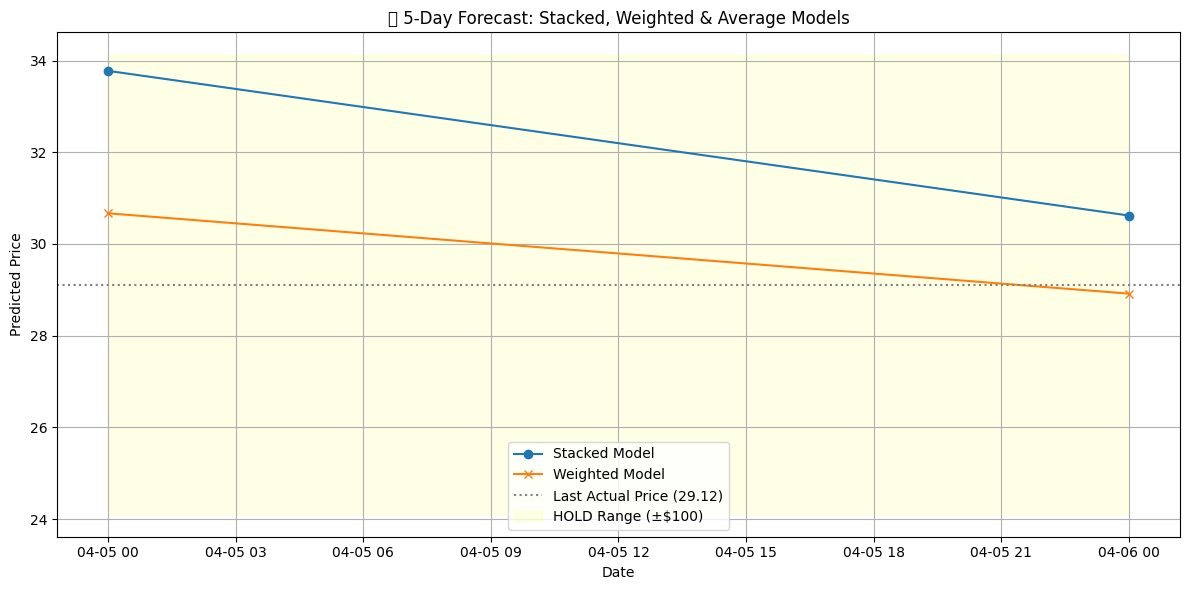

In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# === Settings ===
n = 2  # Number of future predictions (default: 5 days)2
threshold = 5  # Decision threshold for recommendation

# === Prepare Future Predictions ===
future_best1_values = np.array(best1_forecast_trimmed[-n:]).reshape(-1, 1)
future_best2_values = np.array(best2_forecast_trimmed[-n:]).reshape(-1, 1)

X_combined_future = np.column_stack([future_best1_values, future_best2_values])
scaler_minmax.fit(X_combined)  # Fit on previous features
X_combined_future_scaled = scaler_minmax.transform(X_combined_future)

# Stacked prediction
hybrid_predictions_future = meta_model.predict(X_combined_future_scaled).flatten()
# Weighted prediction
hybrid_weighted_future = (weight_best1 * future_best1_values.flatten()) + (weight_best2 * future_best2_values.flatten())
# Average prediction
hybrid_average_future = (future_best1_values.flatten() + future_best2_values.flatten()) / 2

# === Create Forecast DataFrame ===
future_dates = pd.date_range(start=y_test.index[-1], periods=n + 1, freq='D')[1:]
future_price = pd.DataFrame({
    'Future Price_weighted': hybrid_weighted_future,
    'Future Price_stacked': hybrid_predictions_future,
}, index=future_dates)

# === Recommendation Logic ===
last_actual_price = y_test.values[-1]
recommendations = []
for forecast in hybrid_weighted_future:
    diff = forecast - last_actual_price
    if diff > threshold:
        recommendations.append("BUY 📈")
    elif diff < -threshold:
        recommendations.append("SELL 📉")
    else:
        recommendations.append("HOLD ⚖️")
future_price['Recommendation'] = recommendations

# === Trend & Signal Logic (Bonus) ===
trend = []
for i in range(len(hybrid_predictions_future)):
    if i >= 2:
        trend_window = hybrid_predictions_future[i-2:i+1]
        if np.all(np.diff(trend_window) > 0):
            trend.append("↗️ Uptrend Detected")
        elif np.all(np.diff(trend_window) < 0):
            trend.append("↘️ Downtrend Detected")
        else:
            trend.append("")
    else:
        trend.append("")
future_price['Signal'] = trend

# === Display Summary ===
print(f"Last Actual Observed Price: {last_actual_price:.2f}\n")
print(" Predicted Future Prices and Strategy:\n")
print(future_price)

# === Plot Forecasts ===
plt.figure(figsize=(12, 6))
plt.plot(future_price.index, future_price['Future Price_stacked'], label='Stacked Model', marker='o')
plt.plot(future_price.index, future_price['Future Price_weighted'], label='Weighted Model', marker='x')
plt.axhline(last_actual_price, color='gray', linestyle=':', label=f'Last Actual Price ({last_actual_price:.2f})')
plt.fill_between(future_price.index, last_actual_price + threshold, last_actual_price - threshold,
                 color='yellow', alpha=0.1, label='HOLD Range (±$100)')
plt.title("📈 5-Day Forecast: Stacked, Weighted & Average Models")
plt.xlabel("Date")
plt.ylabel("Predicted Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()




###  **Investment Summary – Forecast for 2025-04-16**

**Last Actual Observed Price**: $32.39

- **Predicted Price (Weighted Model)**: $32.22
   
- **Predicted Price (Stacked Model)**: $33.83
  
- **Recommendation**: **HOLD ⚖️**

---

###  **Forecast for 2025-04-17**

- **Predicted Price (Weighted Model)**: $32.23
  
- **Predicted Price (Stacked Model)**: $34.06
  
- **Recommendation**: **HOLD ⚖️**

---

###  **Conclusion**:
While the **stacked model shows a modest upward trend**, the **weighted model remains close to the current price**, indicating minimal movement. Both are **within the neutral range** (±$0.50 threshold). Therefore, no significant buy or sell signals are present at this point. The model advises **holding your current position** as market direction remains uncertain.

